In [9]:
import keras
import numpy as np
from keras.layers import Dense,Input,Conv2D,MaxPooling2D,Flatten,UpSampling2D
from keras.models import Sequential,Model,load_model
import os
from skimage import io,transform
from sklearn.cluster import KMeans
import gc

np.random.seed(10)

# Preprocess

In [2]:
def process(M):
    M-=np.min(M)
    M/=np.max(M)
    M=(M*255).astype("uint8")
    return M
    
def normalize(M):
    mean=np.mean(M,axis=0)
    std=np.std(M,axis=0)
    for i in range(M.shape[0]):
        M[i]=(M[i]-mean)/(std+1e-5)
    return M

In [3]:
%%time
imgSize=64
intSample=20000

dir_path='data/images'
dataFile=os.listdir(dir_path)
all_img=np.zeros((intSample,imgSize,imgSize,3),dtype="float64")
for i in range(intSample):
    img=io.imread(os.path.join(dir_path,dataFile[i]))
    img=transform.resize(img,(imgSize,imgSize,3))
    all_img[i]=img.reshape(imgSize,imgSize,3)
all_img=normalize(all_img)
print(all_img.shape)

(20000, 64, 64, 3)
CPU times: user 1min 1s, sys: 3.69 s, total: 1min 5s
Wall time: 2min 10s


In [4]:
train_x=all_img
train_y=all_img
print(train_x.shape)
print(train_y.shape)

(20000, 64, 64, 3)
(20000, 64, 64, 3)


# Create model

In [5]:
model=Sequential()
# encoder
model.add(Conv2D(16,(3,3),activation='relu',padding='same',input_shape=(64,64,3)))
model.add(MaxPooling2D(2,2, padding='same'))
model.add(Conv2D(8,(3,3),activation='relu', padding='same'))
model.add(MaxPooling2D((4,4),name='encoder'))

# decoder
model.add(Conv2D(8,(3,3),activation='relu',padding='same'))
# model.add(Conv2D(8,(3,3),activation='relu', name='test'))
model.add(UpSampling2D((4,4)))
model.add(Conv2D(16,(3,3),activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(3,(3,3),activation='relu', padding='same',name='decoder'))

model.compile(optimizer='adam',loss='mse',metrics=['acc'])
model.build()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 8)         1160      
_________________________________________________________________
encoder (MaxPooling2D)       (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 8)           584       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 16)        1168      
__________

# Train

In [6]:
%%time
train_history=model.fit(train_x,train_y,epochs=30,validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
16000/16000 [==============================] - 55s 3ms/step - loss: 0.5833 - acc: 0.5599 - val_loss: 0.5294 - val_acc: 0.6047
Epoch 2/30
16000/16000 [==============================] - 62s 4ms/step - loss: 0.5180 - acc: 0.6219 - val_loss: 0.5182 - val_acc: 0.6475
Epoch 3/30
16000/16000 [==============================] - 62s 4ms/step - loss: 0.5103 - acc: 0.6411 - val_loss: 0.5127 - val_acc: 0.6469
Epoch 4/30
16000/16000 [==============================] - 60s 4ms/step - loss: 0.5066 - acc: 0.6482 - val_loss: 0.5114 - val_acc: 0.6635
Epoch 5/30
16000/16000 [==============================] - 59s 4ms/step - loss: 0.5048 - acc: 0.6515 - val_loss: 0.5090 - val_acc: 0.6555
Epoch 6/30
16000/16000 [==============================] - 63s 4ms/step - loss: 0.5038 - acc: 0.6539 - val_loss: 0.5082 - val_acc: 0.6626
Epoch 7/30
16000/16000 [==============================] - 66s 4ms/step - loss: 0.5028 - acc: 0.6558 - val_loss: 0.5073 - val_acc:

# 可視化

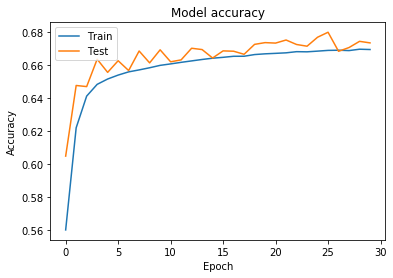

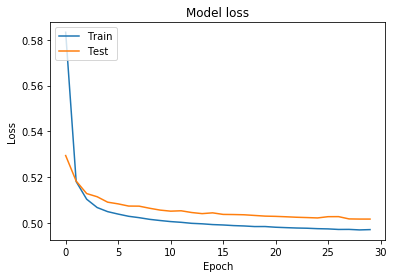

In [34]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('accuracy.png')
plt.show()

# Plot training & validation loss values
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('loss.png')
plt.show()

In [12]:
model=load_model('weight.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 8)         1160      
_________________________________________________________________
encoder (MaxPooling2D)       (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 8)           584       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 16)        1168      
__________

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


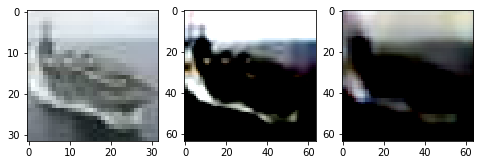

In [11]:
import matplotlib.pyplot as plt

# test_id要大於intSample
test_id=26594
test_img_original=io.imread(os.path.join(dir_path,dataFile[test_id]))
test_img=transform.resize(test_img_original,(imgSize,imgSize,3))
prediction=model.predict(normalize(test_img).reshape(1,64,64,3))

fig=plt.figure(figsize=(8,8))
# 顯示原圖
ax=fig.add_subplot(1,3,1)
ax.imshow(test_img_original)
# 顯示normalize過後的圖片
ax=fig.add_subplot(1,3,2)
ax.imshow(normalize(test_img))
# 顯示預測的圖片
ax=fig.add_subplot(1,3,3)
ax.imshow(process(prediction).reshape(64,64,3))

In [8]:
model.save('weight.h5')

# Prediction

In [21]:
model=keras.models.load_model('weight.h5')

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 8)         1160      
_________________________________________________________________
encoder (MaxPooling2D)       (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 8)           584       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 16)        1168      
__________

In [31]:
encoder=Model([model.get_input_at(0)],[model.get_layer('encoder').output])
encoder.summary()

In [36]:
%%time
intSample=20000
img_encoder=encoder.predict(all_img)
print(img_encoder.shape)

(20000, 8, 8, 8)
CPU times: user 11.6 s, sys: 966 ms, total: 12.6 s
Wall time: 3.72 s


In [39]:
img_encoder=img_encoder.reshape(intSample,-1)

# KMean
### 看不出結果

In [46]:
km=KMeans(n_clusters=2
         ,max_iter=300
         ,n_init=10,)
y_km=km.fit_predict(img_encoder)

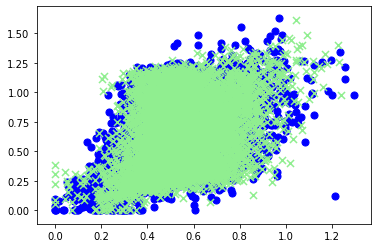

In [47]:
plt.scatter(img_encoder[y_km==0,0]
           ,img_encoder[y_km==0,1]
           ,s=50,c='blue'
           ,marker='o',label='cluster 1')

plt.scatter(img_encoder[y_km==1,0]
           ,img_encoder[y_km==1,1]
           ,s=50,c='lightgreen'
           ,marker='x',label='cluster 1')

plt.show()

In [49]:
print(y_km)
print(y_km.shape)

[1 0 0 ... 0 1 1]
(20000,)
